In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import imblearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score,f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import f_classif,chi2
from sklearn import tree
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency 
import random

import scipy.stats as stats 

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#data = pd.read_csv("C:/Users/ual-laptop/Downloads/train_data.csv"", sep = "|",nrows = 120000)
#data["label"].value_counts()

In [2]:
# Take random sample from the data


columns = ['label', 'uid', 'task_id', 'adv_id', 'creat_type_cd', 'adv_prim_id',
       'dev_id', 'inter_type_cd', 'slot_id', 'spread_app_id', 'tags',
       'app_first_class', 'app_second_class', 'age', 'city', 'city_rank',
       'device_name', 'device_size', 'career', 'gender', 'net_type',
       'residence', 'his_app_size', 'his_on_shelf_time', 'app_score',
       'emui_dev', 'list_time', 'device_price', 'up_life_duration',
       'up_membership_grade', 'membership_life_duration', 'consume_purchase',
       'communication_onlinerate', 'communication_avgonline_30d', 'indu_name',
       'pt_d']



data = pd.DataFrame()

for i in range(1,51):
       #print(i)
       s = 10000*(i-1)
       df = pd.read_csv("C:/Users/ual-laptop/Downloads/train_data.csv", sep = "|",skiprows=s,nrows = 10000)
       df.columns = columns
       skip = sorted(random.sample(range(10000),2400))
       df = df.iloc[skip]
       if i==1:
              data = df.copy()
       else:
              data = data.append(df,ignore_index=True)


    
    


# EDA and Feature Engineering

In [3]:
continous_cols = ["age","city_rank","device_size","his_app_size","his_on_shelf_time",
                  "app_score","emui_dev","list_time","device_price","up_life_duration",
                  "membership_life_duration","consume_purchase","communication_avgonline_30d","pt_d"]
categorical_cols = data.drop(columns = continous_cols).columns
categorical_cols = categorical_cols[1:len(categorical_cols)]
print(categorical_cols)

Index(['uid', 'task_id', 'adv_id', 'creat_type_cd', 'adv_prim_id', 'dev_id',
       'inter_type_cd', 'slot_id', 'spread_app_id', 'tags', 'app_first_class',
       'app_second_class', 'city', 'device_name', 'career', 'gender',
       'net_type', 'residence', 'up_membership_grade',
       'communication_onlinerate', 'indu_name'],
      dtype='object')


In [4]:
## Reduce number of classes 

task_counts = pd.DataFrame()
for s in set(data["task_id"]):
    task_counts = task_counts.append({"name":s,"count":len(data[data["task_id"]==s])},ignore_index = True)

adv_counts = pd.DataFrame()
for s in set(data["adv_id"]):
    adv_counts = adv_counts.append({"name":s,"count":len(data[data["adv_id"]==s])},ignore_index = True)

city_counts = pd.DataFrame()
for s in set(data["city"]):
    city_counts = city_counts.append({"name":s,"count":len(data[data["city"]==s])},ignore_index = True)

## greater than 1 percent
new_task_ids = list(task_counts[task_counts["count"]>1200]["name"])
new_adv_ids = list(adv_counts[adv_counts["count"]>1200]["name"])
new_city_ids = list(city_counts[city_counts["count"]>1200]["name"])

# transformed data
tf_data = data.copy()

def changeTaskid(row):
    if row["task_id"] in new_task_ids:
        return new_task_ids[new_task_ids.index(row["task_id"])]
    else:
        return 0

def changeAdvid(row):
    if row["adv_id"] in new_adv_ids:
        return new_adv_ids[new_adv_ids.index(row["adv_id"])]
    else:
        return 0

def changeCity(row):
    if row["city"] in new_city_ids:
        return new_city_ids[new_city_ids.index(row["city"])]
    else:
        return 0


tf_data["task_id"] = tf_data.apply(lambda x: changeTaskid(x),axis =1)
tf_data["adv_id"] = tf_data.apply(lambda x: changeAdvid(x),axis =1)
tf_data["city"] = tf_data.apply(lambda x: changeCity(x),axis =1)



In [5]:
#ANOVA for continous variables

alpha = 0.01
f_values,p_values = f_classif(data[continous_cols], data["label"])
anova = pd.DataFrame()
anova["columns"] = continous_cols
anova["Fvalue"] = f_values
anova["Pvalue"] = p_values

anova

,columns,Fvalue,Pvalue
0,age,6.706499,9.607376e-03
1,city_rank,84.135320,4.690667e-20
2,device_size,6.784635,9.195714e-03
3,his_app_size,43.690087,3.863178e-11
4,his_on_shelf_time,252.363261,9.062241e-57
5,app_score,263.208685,3.964442e-59
6,emui_dev,54.427700,1.623081e-13
7,list_time,39.489462,3.309615e-10
8,device_price,403.871978,1.111849e-89
9,up_life_duration,114.964129,8.240898e-27


In [6]:
Unique_values = []
for c in categorical_cols:
    Unique_values.append({c:len(set(data[c]))})
Unique_values

[{'uid': 96555},
 {'task_id': 1706},
 {'adv_id': 1903},
 {'creat_type_cd': 8},
 {'adv_prim_id': 76},
 {'dev_id': 40},
 {'inter_type_cd': 3},
 {'slot_id': 12},
 {'spread_app_id': 51},
 {'tags': 24},
 {'app_first_class': 3},
 {'app_second_class': 16},
 {'city': 342},
 {'device_name': 81},
 {'career': 9},
 {'gender': 3},
 {'net_type': 5},
 {'residence': 34},
 {'up_membership_grade': 4},
 {'communication_onlinerate': 249},
 {'indu_name': 30}]

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

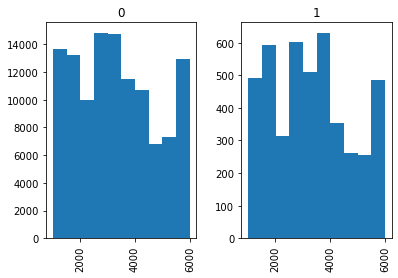

In [7]:
data.hist(column = "task_id", by = "label")

In [8]:
p_values = pd.DataFrame()

for c in categorical_cols[1:len(categorical_cols)]:
        
    chisqt = pd.crosstab(data["label"], data[c], margins=True)

    value = np.array([chisqt.iloc[0][0:len(set(data[c]))+2].values,
                      chisqt.iloc[1][0:len(set(data[c]))+2].values])
    c = chi2_contingency(value)[0:3]
    d = {"statistic":c[0],"p-value":c[1],"dof":c[2]}
    p_values = p_values.append(d,ignore_index=True)



In [9]:
p_values["column"] = categorical_cols[1:len(categorical_cols)]
sorted(p_values["p-value"])

[1.158722434037086e-236,
 1.759287811564292e-218,
 4.683389453076715e-197,
 5.069315711438875e-174,
 1.900356961275527e-153,
 1.2800085973583214e-142,
 1.8773738863968934e-102,
 5.8356706521606504e-83,
 2.0119303388561998e-81,
 1.2640605258330174e-66,
 6.0086668512371225e-62,
 2.1025252251812127e-45,
 3.377174239234506e-43,
 8.603012163865856e-38,
 1.2428801034957e-35,
 7.592211843030495e-29,
 3.3322087820927984e-12,
 1.4127498226159466e-11,
 0.00010144018940554694,
 0.006010611904369958]

In [10]:
p_values[p_values["p-value"]<=sorted(p_values["p-value"])[10]]["column"]

0              task_id
1               adv_id
3          adv_prim_id
4               dev_id
6              slot_id
7        spread_app_id
8                 tags
9      app_first_class
10    app_second_class
12         device_name
19           indu_name
Name: column, dtype: object

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

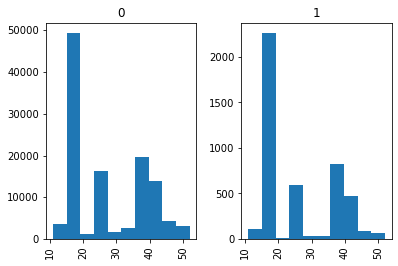

In [11]:
data.hist("indu_name","label")

In [12]:
encoded_data = pd.get_dummies(tf_data, columns = ['task_id', 'adv_id', 'creat_type_cd', 'adv_prim_id',
       'dev_id', 'inter_type_cd', 'slot_id', 'spread_app_id', 'tags',
       'app_first_class', 'app_second_class', 'city', 'device_name', 'career',
       'gender', 'net_type', 'residence', 'up_membership_grade',
        'indu_name'])





In [13]:

X = encoded_data.drop(columns = ["label"])
y = encoded_data["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
X_train.describe()

,uid,age,city_rank,device_size,his_app_size,his_on_shelf_time,app_score,emui_dev,list_time,device_price,...,indu_name_37,indu_name_38,indu_name_39,indu_name_42,indu_name_45,indu_name_46,indu_name_47,indu_name_50,indu_name_51,indu_name_52
count,9.600000e+04,96000.000000,96000.000000,96000.000000,96000.000000,96000.000000,96000.000000,96000.000000,96000.000000,96000.000,...,96000.000000,96000.000000,96000.000000,96000.000000,96000.000000,96000.000000,96000.000000,96000.000000,96000.000000,96000.000000
mean,1.615853e+06,4.670333,3.851281,158.426146,6.302479,1.922187,1.785604,19.192635,9.127646,3.491,...,0.002698,0.020771,0.003323,0.119969,0.000573,0.007833,0.028167,0.008500,0.012094,0.005844
std,3.575122e+05,1.835183,0.908768,45.320230,5.640946,1.577865,0.410405,4.492133,3.627073,1.165,...,0.051872,0.142617,0.057549,0.324927,0.023929,0.088159,0.165450,0.091803,0.109305,0.076221
min,1.000014e+06,-1.000000,2.000000,103.000000,-1.000000,-1.000000,1.000000,11.000000,-2.000000,-1.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.306001e+06,4.000000,3.000000,141.000000,4.000000,2.000000,2.000000,14.000000,7.000000,3.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.613386e+06,5.000000,4.000000,141.000000,5.000000,3.000000,2.000000,20.000000,9.000000,4.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.925308e+06,6.000000,5.000000,162.000000,11.000000,3.000000,2.000000,20.000000,12.000000,4.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.237671e+06,7.000000,5.000000,349.000000,21.000000,3.000000,2.000000,28.000000,17.000000,7.000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
X_train

,uid,age,city_rank,device_size,his_app_size,his_on_shelf_time,app_score,emui_dev,list_time,device_price,...,indu_name_37,indu_name_38,indu_name_39,indu_name_42,indu_name_45,indu_name_46,indu_name_47,indu_name_50,indu_name_51,indu_name_52
53541,2160975,6,3,156,16,3,2,14,6,1,...,0,0,0,0,0,0,0,0,0,0
41728,2074216,7,5,141,4,2,2,14,13,2,...,0,0,0,0,0,0,0,0,0,0
74819,1745798,7,3,156,13,3,2,14,7,1,...,0,0,0,0,0,0,0,0,0,0
106459,2090546,2,4,193,2,3,2,14,13,2,...,0,0,0,0,0,0,0,0,0,0
63062,1576879,4,3,217,-1,-1,1,20,4,4,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,1551660,6,3,156,9,3,2,14,6,1,...,0,0,0,0,0,0,0,0,0,0
119879,1147391,2,5,193,9,3,2,17,14,4,...,0,0,0,0,0,0,0,0,0,0
103694,1296799,5,4,141,11,2,2,20,4,5,...,0,0,0,0,0,0,0,0,0,0
860,1892045,-1,2,218,-1,-1,1,14,-1,-1,...,0,0,0,0,0,0,0,0,0,0


In [16]:
len(X_train.columns)

462

<AxesSubplot:>

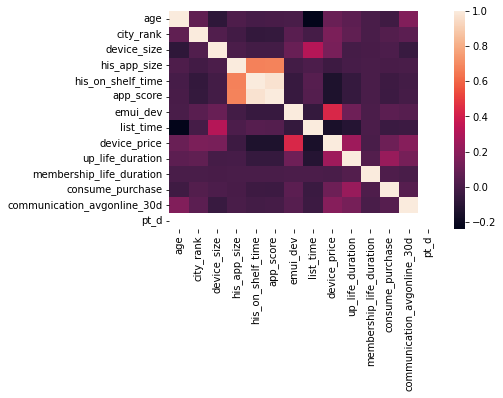

In [17]:
sns.heatmap(X_train[continous_cols].corr())

In [18]:
X_train[continous_cols].corr()

,age,city_rank,device_size,his_app_size,his_on_shelf_time,app_score,emui_dev,list_time,device_price,up_life_duration,membership_life_duration,consume_purchase,communication_avgonline_30d,pt_d
age,1.000000,0.066878,-0.085977,0.016581,-0.008809,-0.002755,-0.000813,-0.238374,0.096851,0.060507,0.000901,-0.032609,0.165032,NaN
city_rank,0.066878,1.000000,0.024521,-0.021916,-0.069906,-0.065493,0.050223,-0.013212,0.152929,0.070751,0.000727,0.030281,0.053052,NaN
device_size,-0.085977,0.024521,1.000000,0.004201,-0.017377,-0.020616,0.091268,0.315244,0.142653,-0.011437,-0.002791,0.012408,-0.052767,NaN
his_app_size,0.016581,-0.021916,0.004201,1.000000,0.674449,0.676281,-0.020326,0.012785,-0.038682,-0.009515,0.001855,-0.006060,0.000678,NaN
his_on_shelf_time,-0.008809,-0.069906,-0.017377,0.674449,1.000000,0.967491,-0.058342,0.037711,-0.136860,-0.063767,0.000316,-0.035677,-0.017672,NaN
app_score,-0.002755,-0.065493,-0.020616,0.676281,0.967491,1.000000,-0.057933,0.033150,-0.139768,-0.060250,-0.000479,-0.040227,-0.011345,NaN
emui_dev,-0.000813,0.050223,0.091268,-0.020326,-0.058342,-0.057933,1.000000,-0.064624,0.433740,0.114699,0.004729,0.056403,0.040404,NaN
list_time,-0.238374,-0.013212,0.315244,0.012785,0.037711,0.033150,-0.064624,1.000000,-0.152015,-0.113983,0.005895,-0.045724,-0.042795,NaN
device_price,0.096851,0.152929,0.142653,-0.038682,-0.136860,-0.139768,0.433740,-0.152015,1.000000,0.245713,-0.000224,0.108825,0.180739,NaN
up_life_duration,0.060507,0.070751,-0.011437,-0.009515,-0.063767,-0.060250,0.114699,-0.113983,0.245713,1.000000,0.030718,0.234922,0.138900,NaN


In [19]:
def convert_communication_onlinerate1(row):
    return int(row["communication_onlinerate"].split("^")[0])

def convert_communication_onlinerate2(row):
    return int(row["communication_onlinerate"].split("^")[-1])

In [20]:
X_train["communication_onlinerate_start"] = X_train.apply( convert_communication_onlinerate1,axis=1)
X_train["communication_onlinerate_end"] = X_train.apply( convert_communication_onlinerate2,axis=1)


X_test["communication_onlinerate_start"] = X_test.apply( convert_communication_onlinerate1,axis=1)
X_test["communication_onlinerate_end"] = X_test.apply( convert_communication_onlinerate2,axis=1)



In [21]:
X_train.drop(columns = continous_cols).columns

Index(['uid', 'communication_onlinerate', 'task_id_0', 'task_id_1184',
       'task_id_1401', 'task_id_1610', 'task_id_2325', 'task_id_2531',
       'task_id_2784', 'task_id_3747',
       ...
       'indu_name_39', 'indu_name_42', 'indu_name_45', 'indu_name_46',
       'indu_name_47', 'indu_name_50', 'indu_name_51', 'indu_name_52',
       'communication_onlinerate_start', 'communication_onlinerate_end'],
      dtype='object', length=450)

In [22]:
X_test["communication_onlinerate_start"] 

71787    0
67218    0
54066    7
7168     1
29618    6
        ..
17283    6
89286   -1
47263    5
83913    5
74735    0
Name: communication_onlinerate_start, Length: 24000, dtype: int64

# Logisitc

In [58]:
X_train.head()
X_train1 = X_train.drop(columns = ["communication_onlinerate","pt_d","uid"])
X_test1 = X_test.drop(columns = ["communication_onlinerate","pt_d","uid"])
len(X_train1.columns)

461

In [24]:

log = LogisticRegression(penalty='l2',C=0.1, solver = "lbfgs",class_weight={0:0.05,1:1})
log.fit(X_train1,y_train)


LogisticRegression(C=0.1, class_weight={0: 0.05, 1: 1})

In [25]:
df = pd.DataFrame()
df["coefs"] = log.coef_[0]
df["name"] = X_train1.columns
df[abs(df["coefs"])!=0]

,coefs,name
0,0.048708,age
1,-0.071437,city_rank
2,0.002318,device_size
3,-0.000316,his_app_size
4,0.087733,his_on_shelf_time
...,...,...
456,-0.014647,indu_name_50
457,-0.024274,indu_name_51
458,-0.013579,indu_name_52
459,-0.027308,communication_onlinerate_start


In [26]:
print(confusion_matrix(log.predict(X_test1),y_test))

[[18065   491]
 [ 5022   422]]


In [27]:
print(recall_score(log.predict(X_test1),y_test))

0.0775165319617928


In [28]:
print(precision_score(log.predict(X_test1),y_test))

0.46221248630887185


In [29]:
print(f1_score(log.predict(X_test1),y_test,average = "weighted"))

0.7009252873074096


In [30]:
print(classification_report(y_test,log.predict(X_test1)))

              precision    recall  f1-score   support

           0       0.97      0.78      0.87     23087
           1       0.08      0.46      0.13       913

    accuracy                           0.77     24000
   macro avg       0.53      0.62      0.50     24000
weighted avg       0.94      0.77      0.84     24000



# Tree

In [31]:
model = DecisionTreeClassifier()
model.fit(X_train1,y_train)



DecisionTreeClassifier()

In [32]:
print(confusion_matrix(y_test,model.predict(X_test1)))



[[22183   904]
 [  856    57]]


In [33]:
roc_auc_score(y_test,model.predict(X_test1))

0.5116376546242933

In [34]:
precision_score(y_test,model.predict(X_test1))

0.05931321540062435

In [35]:
recall_score(y_test,model.predict(X_test1))

0.0624315443592552

In [36]:
len(X_train)
len(X_test)
len(y_test[y_test==1])

913

In [37]:
print(classification_report(model.predict(X_test1),y_test))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     23039
           1       0.06      0.06      0.06       961

    accuracy                           0.93     24000
   macro avg       0.51      0.51      0.51     24000
weighted avg       0.92      0.93      0.93     24000



# Random Forest

In [38]:
m2 = RandomForestClassifier()
m2.fit(X_train1,y_train)


RandomForestClassifier()

In [39]:
print(confusion_matrix(m2.predict(X_test1),y_test))

[[23071   898]
 [   16    15]]


In [40]:
roc_auc_score(y_test,m2.predict(X_test1))

0.507868161534414

In [41]:
print(classification_report(m2.predict(X_test1),y_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     23969
           1       0.02      0.48      0.03        31

    accuracy                           0.96     24000
   macro avg       0.51      0.72      0.51     24000
weighted avg       1.00      0.96      0.98     24000



# XGBoost

In [42]:

X1 = tf_data.drop(columns = ["label"])
y1 = tf_data["label"]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

X1_train["communication_onlinerate_start"] = X1_train.apply( convert_communication_onlinerate1,axis=1)
X1_train["communication_onlinerate_end"] = X1_train.apply( convert_communication_onlinerate2,axis=1)


X1_test["communication_onlinerate_start"] = X1_test.apply( convert_communication_onlinerate1,axis=1)
X1_test["communication_onlinerate_end"] = X1_test.apply( convert_communication_onlinerate2,axis=1)

X1_train1 = X1_train.drop(columns = ["communication_onlinerate","pt_d","uid"])
X1_test1 = X1_test.drop(columns = ["communication_onlinerate","pt_d","uid"])



In [43]:
m3 = xgb.XGBClassifier(use_label_encoder=False)
m3.fit(X1_train1,y_train)


[20:51:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [44]:
print(confusion_matrix(y_test,m3.predict(X1_test1)))

[[23082     5]
 [  910     3]]


In [45]:
roc_auc_score(y_test,m3.predict(X1_test1))

0.5015346493294497

# SMOTE

### Undersampling

In [46]:
#Under sampling
rus = RandomUnderSampler(random_state=42,replacement=True)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(X_train1, y_train)


## Undersampling with different class 0 samples

In [82]:
ratio = [0.05,0.1,0.15,0.20,0.25,0.30,0.35,0.4,0.45,0.5]
n1 = 92521
n2 = 3479
precision_scores = []
recall_scores = []

x1 = X_train1[y_train==1]
x0 = X_train1[y_train==0]
y1 = y_train[y_train==1]







In [83]:
for r in ratio:
    
    
    sample_size =  int(float(n2)*(1/r-1))
    subset_index= sorted(random.sample(range(0,len(x0)),sample_size))

    x0 = x0.iloc[subset_index]
    x_rus = x1.append(x0)    
    y0 = y_train[y_train==0].iloc[subset_index]
    y_rus = y1.append(y0)


    #len(x_rus.columns)
    #models = [ DecisionTreeClassifier(),RandomForestClassifier(),xgb.XGBClassifier(use_label_encoder=False)]
    m = RandomForestClassifier()
    m.fit(x_rus,y_rus)
    precision_scores.append(precision_score(y_test,m.predict(X_test1)))
    recall_scores.append(recall_score(y_test,m.predict(X_test1)))

In [79]:
f1_scores = []
for i in range(0,10):
    f1_scores.append(2*precision_scores[i]*recall_scores[i]/(precision_scores[i]+recall_scores[i]))


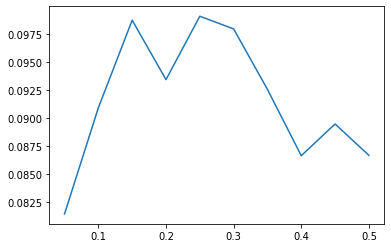

In [80]:
plt.plot(ratio,f1_scores)

In [57]:
X_test1
#recall_score(y_test,m.predict(X_test1))

,age,city_rank,device_size,his_app_size,his_on_shelf_time,app_score,emui_dev,list_time,device_price,up_life_duration,...,indu_name_39,indu_name_42,indu_name_45,indu_name_46,indu_name_47,indu_name_50,indu_name_51,indu_name_52,communication_onlinerate_start,communication_onlinerate_end
71787,3,3,141,6,3,2,14,8,4,-1,...,0,0,0,0,0,0,0,0,0,23
67218,4,3,141,5,3,2,12,9,3,-1,...,0,1,0,0,0,0,0,0,0,23
54066,5,5,141,13,3,2,27,4,5,20,...,0,0,0,0,0,0,0,1,7,23
7168,5,4,162,14,2,2,20,4,5,20,...,0,0,0,0,0,0,0,0,1,23
29618,1,3,141,4,3,2,20,8,4,-1,...,0,0,0,0,0,0,0,0,6,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17283,7,4,117,11,2,2,14,9,3,-1,...,0,0,0,0,0,0,0,0,6,23
89286,5,5,287,13,3,2,20,4,5,20,...,0,0,0,0,0,0,0,0,-1,-1
47263,4,3,141,-1,-1,1,20,10,2,-1,...,0,0,0,0,0,0,0,0,5,23
83913,5,5,141,9,3,2,20,4,5,-1,...,0,0,0,0,0,0,0,0,5,23


In [ ]:
max(f1_score)

In [82]:
ratio = 0.04
n1 = 92521
n2 = 3479
sample_size =  int(n2*(1/ratio - 1))
subset_index= sorted(random.sample(range(n1),sample_size))

max(subset_index)
#print(sample_size)
#x1 = X_train1[y_train==1]
#x0 = X_train1[y_train==0]
#x0 = x0.iloc[subset_index]

#y1 = y_train[y_train==1].reset_index()
#y0 = y_train[y_train==0].reset_index().iloc[subset_index]
#y_rus = y1.append(x0)






92520

In [576]:
y_train.value_counts()

0    92521
1     3479
Name: label, dtype: int64

In [ ]:
print(y_rus.value_counts())

0    3532
1    3532
Name: label, dtype: int64


In [ ]:
#Tree
model = DecisionTreeClassifier()
model.fit(x_rus,y_rus)
print(confusion_matrix(y_test,model.predict(X_test1)))


[[13008 10097]
 [  399   496]]


In [ ]:
roc_auc_score(y_test,model.predict(X_test1))

0.5585924834282163

In [ ]:
precision_score(y_test,model.predict(X_test1))

0.046823373926177664

In [ ]:
## TP/(TP+FN)
recall_score(y_test,model.predict(X_test1))

0.5541899441340782

In [ ]:
print(classification_report(model.predict(X_test1),y_test))

              precision    recall  f1-score   support

           0       0.56      0.97      0.71     13407
           1       0.55      0.05      0.09     10593

    accuracy                           0.56     24000
   macro avg       0.56      0.51      0.40     24000
weighted avg       0.56      0.56      0.44     24000



In [ ]:
# Forest
m2 = RandomForestClassifier()
m2.fit(x_rus,y_rus)
print(confusion_matrix(y_test,m2.predict(X_test1)))

[[15369  7736]
 [  379   516]]


In [ ]:
roc_auc_score(y_test,m2.predict(X_test1),)

0.6208585048340163

In [ ]:
precision_score(y_test,m2.predict(X_test1))

0.06253029568589433

In [ ]:
## TP/(TP+FN)
recall_score(y_test,m2.predict(X_test1))

0.576536312849162

In [ ]:
print(classification_report(y_test,m2.predict(X_test1)))

              precision    recall  f1-score   support

           0       0.98      0.67      0.79     23105
           1       0.06      0.58      0.11       895

    accuracy                           0.66     24000
   macro avg       0.52      0.62      0.45     24000
weighted avg       0.94      0.66      0.77     24000



In [ ]:
#XGBoost
x1_rus, y_rus = rus.fit_resample(X1_train1, y_train)

m3 = xgb.XGBClassifier(use_label_encoder=False)
m3.fit(x1_rus,y_rus)
print(confusion_matrix(y_test,m3.predict(X1_test1)))

[18:00:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[14182  8923]
 [  371   524]]


In [ ]:
roc_auc_score(y_test,m3.predict(X1_test1))

0.5996406978585738

In [ ]:
precision_score(y_test,m3.predict(X1_test1))

0.05546734413041177

In [ ]:
recall_score(y_test,m3.predict(X1_test1))


0.5854748603351956

In [ ]:
f1_score(y_test,m3.predict(X1_test1),average="weighted")

0.7288907008566622

In [ ]:
print(classification_report(y_test,m3.predict(X1_test1)))

              precision    recall  f1-score   support

           0       0.97      0.61      0.75     23105
           1       0.06      0.59      0.10       895

    accuracy                           0.61     24000
   macro avg       0.51      0.60      0.43     24000
weighted avg       0.94      0.61      0.73     24000



### Oversampling

In [556]:
# oversampling
from imblearn.over_sampling import SMOTE, ADASYN
# fit predictor and target variable
x_ros, y_ros = ADASYN().fit_resample(X_train1, y_train)

# Tree
model = DecisionTreeClassifier()
model.fit(x_ros,y_ros)


DecisionTreeClassifier()

In [557]:


y_ros.value_counts()

0    92521
1    92042
Name: label, dtype: int64

In [558]:
print(confusion_matrix(y_test,model.predict(X_test1)))

[[22113   986]
 [  829    72]]


In [559]:
roc_auc_score(y_test,model.predict(X_test1))

0.5186126896057452

In [560]:
precision_score(y_test,model.predict(X_test1))

0.06805293005671077

In [561]:
recall_score(y_test,model.predict(X_test1))

0.07991120976692564

In [562]:
print(classification_report(y_test,model.predict(X_test1)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     23099
           1       0.07      0.08      0.07       901

    accuracy                           0.92     24000
   macro avg       0.52      0.52      0.52     24000
weighted avg       0.93      0.92      0.93     24000



In [563]:
## Random Forest

m2 = RandomForestClassifier()
m2.fit(x_ros,y_ros)
print(confusion_matrix(y_test,m2.predict(X_test1)))

[[23066    33]
 [  890    11]]


In [564]:
roc_auc_score(y_test,m2.predict(X_test1))

0.5053900118867785

In [565]:
recall_score(y_test,m2.predict(X_test1))

0.01220865704772475

In [566]:
print(classification_report(y_test,m2.predict(X_test1)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     23099
           1       0.25      0.01      0.02       901

    accuracy                           0.96     24000
   macro avg       0.61      0.51      0.50     24000
weighted avg       0.94      0.96      0.94     24000



In [568]:
##XGBoost
x1_ros, y_ros = ADASYN().fit_resample(X1_train1, y_train)  

m3 = xgb.XGBClassifier(use_label_encoder=False)
m3.fit(x1_ros,y_ros)
print(confusion_matrix(y_test,m3.predict(X1_test1)))

[18:12:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[22823   276]
 [  886    15]]


In [569]:
roc_auc_score(y_test,m3.predict(X1_test1))

0.5023497997496564

In [570]:
recall_score(y_test,m3.predict(X1_test1))

0.016648168701442843

In [571]:
precision_score(y_test,m3.predict(X1_test1))

0.05154639175257732

In [ ]:
y_test.value_counts()


0    23105
1      895
Name: label, dtype: int64